# Currently implemented OWL models

In this notebook we will go through the various models that are already implemented in the owl package.

To use this tutorial, you should have installed the owl package.

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Regression model: Linear regression

The `LinearRegression` class from `owl.regression` is basically a wrapper around the `LinearRegression` class from `sklearn.linear_model`. We can fit a standard least-squares solution using the `.maximize_weighted_likelihood()` method, and fit an OWL solution by using the `.fit_owl(ball=ball)` method where `ball` is an instance of the `ProbabilityBall` class from `owl.ball`.

The underlying sklearn linear regression object is stored in the field `clf`.

In [2]:
## Import OWL module
from owl.regression import LinearRegression
from owl.ball import L1Ball

n = 500

## Set our random seed
np.random.seed(100)

## Generate some random data (500 data points in 3 dimensions)
X = np.random.standard_normal(size=(n,3))

## Ground truth is all ones vector
w = np.ones(3)

## Homoscedastic normal noise
eff = np.dot(X,w)
y = eff + np.random.standard_normal(n)

## Randomly corrupt 10% of the data
epsilon = 0.1
corrupt_inds = np.random.choice(n, size=int(n*epsilon), replace=False)
max_val = np.max(np.abs(y))
for i in corrupt_inds:
    y[i] = 10*max_val*np.sign(eff[i])
    
## Fit a maximum likelihood estimate to the data
mle = LinearRegression(X=X, y=y)
mle.maximize_weighted_likelihood()

## Fit an OWL estimate to the data
l1ball = L1Ball(n=n, r=2*epsilon)
rob = LinearRegression(X=X, y=y)
rob.fit_owl(ball=l1ball, n_iters=10, verbose=True)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37it/s]


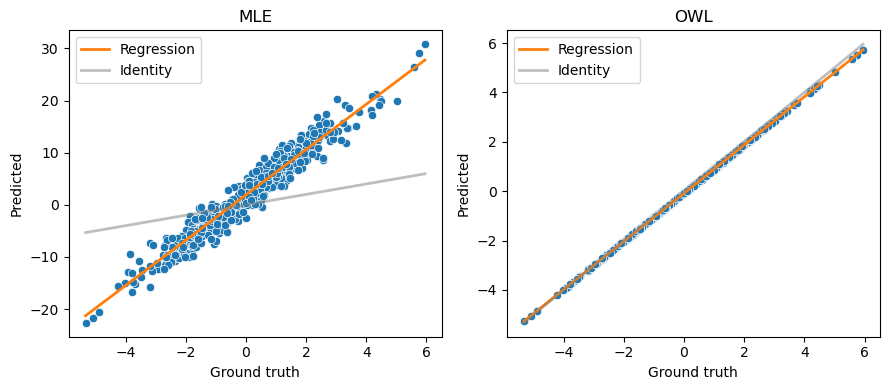

In [3]:
mle_eff = mle.predict(X)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
sns.scatterplot(x=eff, y=mle_eff, ax=axs[0])


a, b = np.polyfit(eff, mle_eff, 1)
axs[0].plot([np.min(eff), np.max(eff)], [a*np.min(eff)+b, a*np.max(eff)+b], color='tab:orange', linewidth=2, label='Regression')
axs[0].plot([np.min(eff), np.max(eff)], [np.min(eff), np.max(eff)], color='tab:gray', linewidth=2, alpha=0.5, label='Identity')
axs[0].legend()


axs[0].set_title("MLE")
axs[0].set_xlabel("Ground truth")
axs[0].set_ylabel("Predicted")


rob_eff = rob.predict(X)
sns.scatterplot(x=eff, y=rob_eff, ax=axs[1])
a, b = np.polyfit(eff, rob_eff, 1)
axs[1].plot([np.min(eff), np.max(eff)], [a*np.min(eff)+b, a*np.max(eff)+b], color='tab:orange', linewidth=2, label='Regression')
axs[1].plot([np.min(eff), np.max(eff)], [np.min(eff), np.max(eff)], color='tab:gray', linewidth=2, alpha=0.5, label='Identity')
axs[1].legend()


axs[1].set_title("OWL")
axs[1].set_xlabel("Ground truth")
axs[1].set_ylabel("Predicted")
plt.tight_layout()

## Regression model: Logistic regression

The `LogisticRegression` class from `owl.regression` is basically a wrapper around the `LogisticRegression` class from `sklearn.linear_model`. Again, we can fit a standard least-squares solution using the `.maximize_weighted_likelihood()` method, and fit an OWL solution by using the `.fit_owl(ball=ball)` method where `ball` is an instance of the `ProbabilityBall` class from `owl.ball`.

The underlying sklearn logistic regression object is stored in the field `clf`. The coefficients of `clf` are not directly interpretable, however, since the data is first passed through a `StandardScaler` object from `sklearn.preprocessing` (this is to improve convergence in fitting the logistic regression solution). Thus, one should keep in mind the parameters in the `scaler` field.

In [4]:
## Import OWL module
from owl.regression import LogisticRegression
from scipy.special import expit

n = 1000

## Generate some random data (500 data points in 3 dimensions)
X = np.random.standard_normal(size=(n,3))

## Ground truth is all ones vector
w = np.ones(3)

## Homoscedastic normal noise
eff = expit(np.dot(X,w))
y = (np.random.rand(n) <= eff).astype(int)

## Corrupt 10% of the data that is most likely under the MLE
epsilon = 0.1
lr = LogisticRegression(X=X, y=y)
lr.maximize_weighted_likelihood()
lls = lr.log_likelihood() ## Get likelihood values
corrupt_inds = np.argsort(-lls)[:int(n*epsilon)] ## Corrupt largest indices
y[corrupt_inds] = (y[corrupt_inds] == 0).astype(int) ## Flip these labels


## Fit a maximum likelihood estimate to the data
mle = LogisticRegression(X=X, y=y)
mle.maximize_weighted_likelihood()

## Fit an OWL estimate to the data
l1ball = L1Ball(n=n, r=2*epsilon)
rob = LogisticRegression(X=X, y=y)
rob.fit_owl(ball=l1ball, n_iters=10, verbose=True)



## Generate fresh data
X_test = np.random.standard_normal(size=(n,3))
ground_truth = (np.dot(X_test,w) > 0).astype(int)


print("MLE accuracy:", np.mean(mle.predict(X_test) == ground_truth))
print("OWL accuracy:", np.mean(rob.predict(X_test) == ground_truth))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]

MLE accuracy: 0.934
OWL accuracy: 0.977


## Mixture model: Gaussian mixture model

The `GeneralGMM` class from `owl.mixture_models` implements a Gaussian mixture model with general covariance matrices. Initializing with the flag `hard=True` will ensure that weighted maximum likelihood estimation will be done via hard EM, and it will also have the effect that log-likelihoods will be computed using the cluster latent variables ($z$-variables). When `hard=False`, the method `.maximize_weighted_likelihood()` will ignore any weights and do standard (soft) EM. 

The method `.fit_mle()` performs EM (hard or soft) with random restarts, keeping the solution that maximizes the likelihood. The method `.fit_owl()` has been overwritten to perform OWL estimation with random restarts, keeping the solution that maximizes the OKL estimate.

The `SphericalGMM` class from `owl.mixture_models` implements a Gaussian mixture model with spherical covariance matrices and has the same semantics as the `GeneralGMM` class.

In [5]:
from owl.mixture_models import GeneralGMM

n = 1000

## Generate data from mixture of two Gaussians
mu1 = np.array([-3., -1.])
cov1 = np.array([[3.0, -0.75],[-0.75, 1.0]])

mu2 = np.array([3., 3.])
cov2 = np.array([[1.0, 0.],[0., 2.0]])

X1 = np.random.multivariate_normal(mean=mu1, cov=cov1, size=int(n/2))
X2 = np.random.multivariate_normal(mean=mu2, cov=cov2, size=int(n/2))

X = np.concatenate([X1,X2])
np.random.shuffle(X)

## Randomly corrupt some fraction of the data
epsilon = 0.1
corrupt_inds = np.random.choice(n, size=int(n*epsilon), replace=False)
for i in corrupt_inds:
    coord = np.random.choice(2)
    X[i, coord] = 10*np.sign(X[i,coord])



In [6]:
mle = GeneralGMM(X=X, K=2, repeats=10, hard=False)
mle.fit_mle()

rob = GeneralGMM(X=X, K=2, repeats=5, hard=True)
l1ball = L1Ball(n=n, r=epsilon)
rob.fit_owl(ball=l1ball, n_iters=10, verbose=True)


ground_truth = GeneralGMM(X=X, K=2)
ground_truth.mu = np.array([mu1,mu2])
ground_truth.prec_mats = np.array([np.linalg.inv(cov1),np.linalg.inv(cov2)])
ground_truth.pi = np.array([0.5,0.5])


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.10it/s]


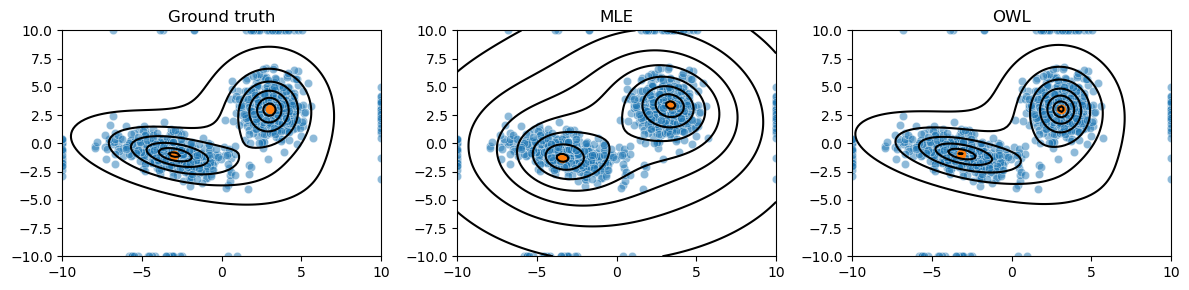

In [7]:
from scipy.spatial.distance import cdist
def prob(X_, Y_, gmm):
    dets = np.linalg.det(gmm.prec_mats)

    A = np.array([X_.flatten(), Y_.flatten()]).T
    probs = np.zeros(len(X_.flatten()))
    for k in range(gmm.K):
        probs += gmm.pi[k] * (0.5/np.pi) * np.sqrt(dets[k]) * np.exp(-0.5*(cdist(A, (gmm.mu[k,:])[np.newaxis,:], metric='mahalanobis', VI=gmm.prec_mats[k])).squeeze())
        
    
    return(probs.reshape(X_.shape))

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X_, Y_ = np.meshgrid(x, y)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

sns.scatterplot(x=X[:,0], y=X[:,1], alpha=0.5, ax=axs[0])
axs[0].set_title("Ground truth")
axs[0].contour(X_, Y_, prob(X_, Y_, ground_truth), colors='black')
axs[0].scatter(ground_truth.mu[:,0], ground_truth.mu[:,1])


sns.scatterplot(x=X[:,0], y=X[:,1], alpha=0.5, ax=axs[1])
axs[1].set_title("MLE")
axs[1].contour(X_, Y_, prob(X_, Y_, mle), colors='black')
axs[1].scatter(mle.mu[:,0], mle.mu[:,1])


sns.scatterplot(x=X[:,0], y=X[:,1], alpha=0.5, ax=axs[2])
axs[2].set_title("OWL")
axs[2].contour(X_, Y_, prob(X_, Y_, rob), colors='black')
axs[2].scatter(rob.mu[:,0], rob.mu[:,1])
plt.tight_layout()
        